# Importation des librairies nécessaires

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# SCIKIT-LEARN: SELECTION DE VARIABLES

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.ensemble import RandomForestClassifier

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 
from sklearn_pandas import DataFrameMapper

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, roc_curve, auc

# SMOTE
from imblearn.over_sampling import SMOTE

# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparer en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation : visulaisr des scores lors du choix d'un hyper-paramètre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper-paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage : visualisation des scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEURll
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# YELLOWBRICK
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

# Importation des modules

In [2]:
# Configuration du chemin d'accès
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importations des modules nécessaires
import data_loader
import preprocessing
import modeling
import evaluation
import cleaning

# Chargement des données

In [6]:
def balance_dataset(data_path, target_column, output_path, random_state=42):
    """
    Équilibre le dataset en assurant que chaque classe ait le même nombre de lignes, 
    basé sur la classe ayant le moins de lignes.

    Parameters:
    - data_path (str): Le chemin du fichier CSV à charger.
    - target_column (str): Le nom de la colonne cible pour équilibrer les classes.
    - output_path (str): Le chemin du fichier CSV où sauvegarder le dataset équilibré.
    - random_state (int): La graine aléatoire pour la reproductibilité (par défaut 42).
    """
    # Charger les données
    df = pd.read_csv(data_path)
    
    # Trouver la taille de la plus petite classe
    min_class_size = df[target_column].value_counts().min()
    
    # Échantillonner chaque classe pour avoir un nombre égal de lignes
    df_balanced = df.groupby(target_column).apply(lambda x: x.sample(min_class_size, random_state=random_state)).reset_index(drop=True)
    
    # Sauvegarder le nouveau dataset
    df_balanced.to_csv(output_path, index=False)
    
    # Vérifier la distribution des classes dans le nouvel ensemble de données
    distribution = df_balanced[target_column].value_counts()
    print("Distribution des classes dans le dataset équilibré :")
    print(distribution)
    
    return df_balanced

In [7]:
data_path = '../data/smoking_driking_dataset_Ver01.csv'
target_column = 'SMK_stat_type_cd' 
output_path = '../data/balanced_smoking_drinking_dataset.csv'

# Équilibrer le dataset
df_balanced = balance_dataset(data_path, target_column, output_path)

Distribution des classes dans le dataset équilibré :
SMK_stat_type_cd
1.0    174951
2.0    174951
3.0    174951
Name: count, dtype: int64


# Nettoyage des données

## Type des variables

In [8]:
intToFloat = ['age', 'height', 'weight']
floatToInt = ['hear_left', 'hear_right', 'urine_protein', 'SMK_stat_type_cd']

In [10]:
cleaning.convertType(df_balanced, intToFloat, floatToInt)

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Female,70.0,155.0,40.0,61.0,0.9,0.9,1,1,124.0,...,141.0,63.0,13.2,2,0.8,30.0,9.0,24.0,1,N
1,Male,75.0,160.0,65.0,82.0,0.5,0.5,2,2,177.0,...,88.0,116.0,13.3,4,0.9,18.0,28.0,29.0,1,N
2,Female,45.0,150.0,55.0,81.0,1.0,1.0,1,1,175.0,...,201.0,104.0,13.8,1,1.0,29.0,25.0,18.0,1,N
3,Female,70.0,155.0,65.0,85.0,0.8,0.7,1,1,166.0,...,147.0,169.0,11.4,1,0.9,28.0,24.0,20.0,1,Y
4,Female,45.0,155.0,55.0,75.5,0.7,0.9,1,1,95.0,...,123.0,176.0,12.7,1,0.8,23.0,23.0,29.0,1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524848,Male,35.0,170.0,65.0,80.2,0.7,0.6,1,1,120.0,...,55.0,51.0,14.1,1,0.5,24.0,31.0,47.0,3,Y
524849,Male,40.0,175.0,60.0,74.0,1.2,0.8,1,1,122.0,...,109.0,125.0,14.8,1,1.2,22.0,17.0,69.0,3,Y
524850,Male,30.0,165.0,75.0,84.0,0.9,1.2,1,1,126.0,...,139.0,240.0,16.5,1,0.5,37.0,57.0,123.0,3,Y
524851,Male,30.0,165.0,70.0,83.5,1.2,1.0,1,1,160.0,...,71.0,51.0,15.6,1,0.8,23.0,25.0,75.0,3,Y


In [11]:
df_balanced.dtypes

sex                  object
age                 float64
height              float64
weight              float64
waistline           float64
sight_left          float64
sight_right         float64
hear_left             int64
hear_right            int64
SBP                 float64
DBP                 float64
BLDS                float64
tot_chole           float64
HDL_chole           float64
LDL_chole           float64
triglyceride        float64
hemoglobin          float64
urine_protein         int64
serum_creatinine    float64
SGOT_AST            float64
SGOT_ALT            float64
gamma_GTP           float64
SMK_stat_type_cd      int64
DRK_YN               object
dtype: object

In [12]:
cont_features = df_balanced.select_dtypes(include=['float64']).columns
cat_features = df_balanced.select_dtypes(include=['object', 'int64']).columns
cat_features = cat_features.drop(['SMK_stat_type_cd', 'DRK_YN'])

In [13]:
cont_features, cat_features

(Index(['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right',
        'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
        'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST',
        'SGOT_ALT', 'gamma_GTP'],
       dtype='object'),
 Index(['sex', 'hear_left', 'hear_right', 'urine_protein'], dtype='object'))

## Outliers

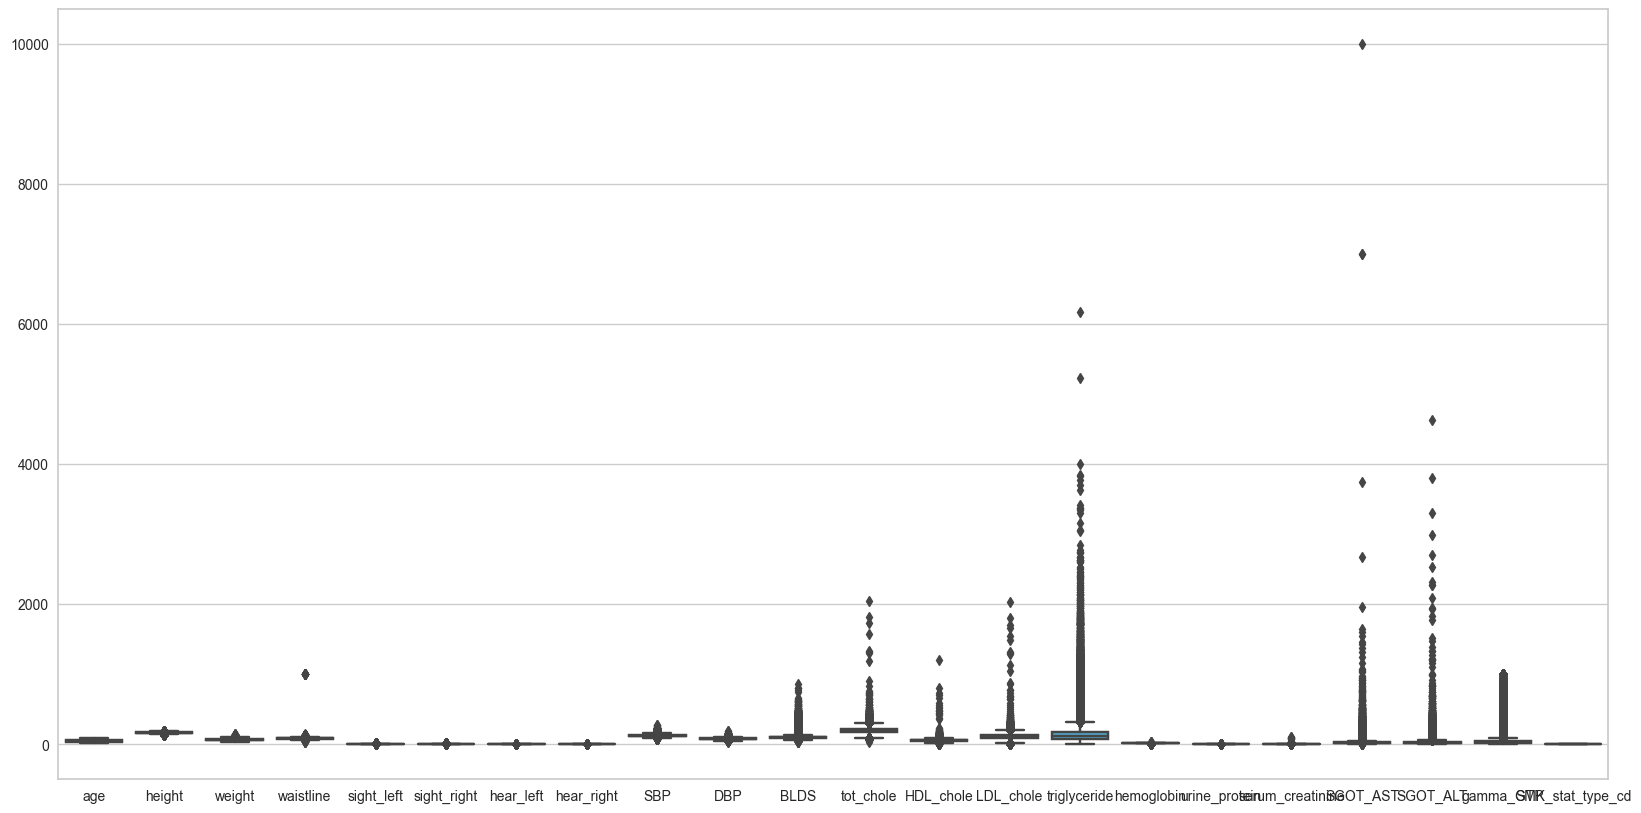

In [14]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_balanced)
plt.show()

In [16]:
col_limits = {
    'triglyceride': 3000,
    'LDL_chole': 3000,
    'HDL_chole': 3000,
    'SGOT_AST': 3000,
    'SGOT_ALT': 3000
}

# Filtrer les outliers
df_balanced = cleaning.filter_outliers(df_balanced, col_limits)

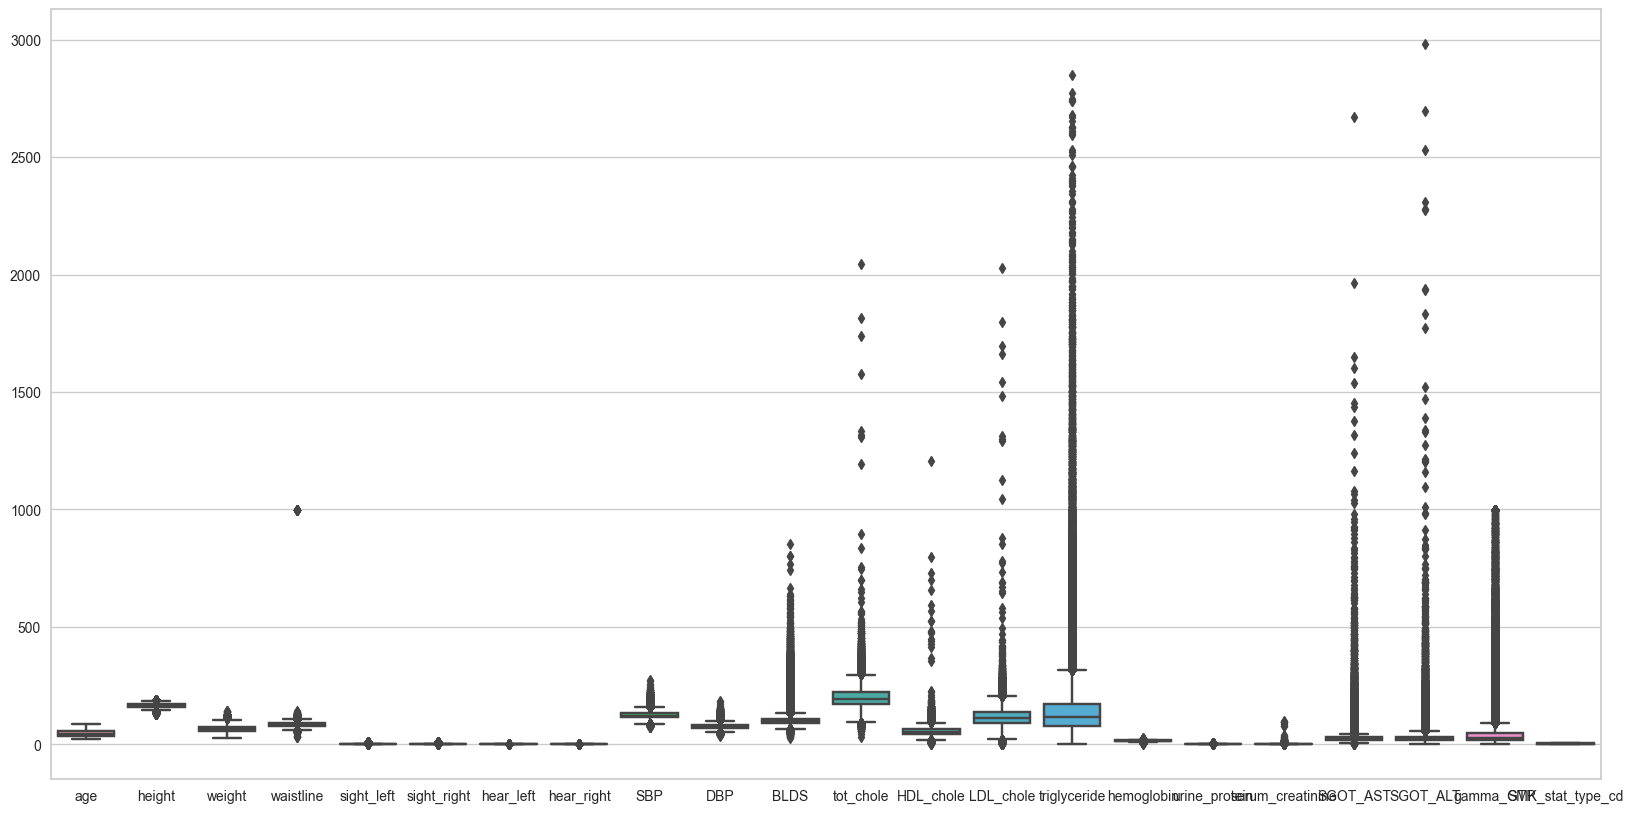

In [17]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_balanced)
plt.show()

# Séparation données train / test

In [18]:
X = df_balanced.drop(columns=['SMK_stat_type_cd', 'DRK_YN'])
y = df_balanced['SMK_stat_type_cd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
y_train.value_counts(), y_test.value_counts()

(SMK_stat_type_cd
 1    139960
 2    139955
 3    139949
 Name: count, dtype: int64,
 SMK_stat_type_cd
 1    34990
 2    34989
 3    34988
 Name: count, dtype: int64)

## Sélection de variables

### Validation croisée pour avoir la meilleure valeur de k features à retenir

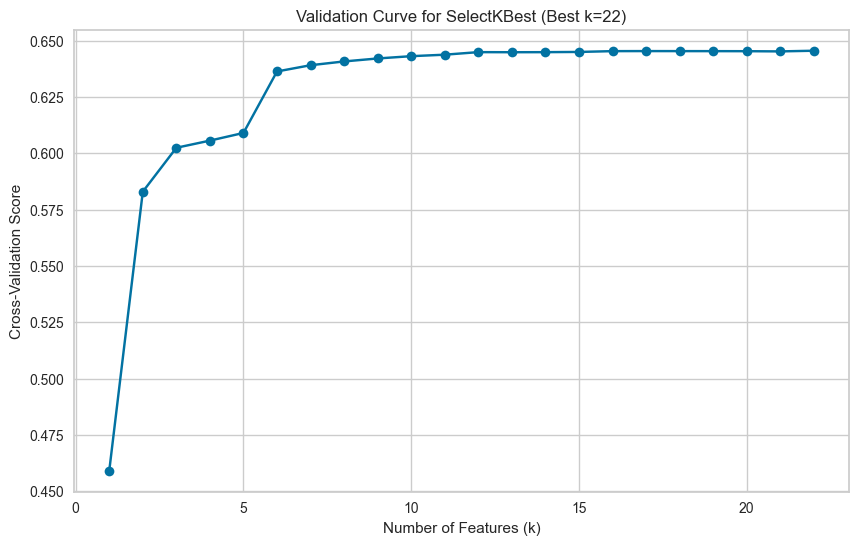

Best k: 22
Best cross-validation score: 0.6454655892324845


In [21]:
def preprocess_data(X_train, X_test, cont_features, cat_features):
    """"
    Renvoie les données prétraitées pour l'entraînement et le test, ainsi que le preprocessor utilisé.
    """
    
    # Preprocess numerical features
    cont_preprocessor = make_pipeline(StandardScaler())
    
    # Preprocess categorical features
    cat_preprocessor = make_pipeline(OrdinalEncoder())
    
    preprocessor = make_column_transformer((cont_preprocessor, cont_features),
                                           (cat_preprocessor, cat_features),
                                           remainder='drop')
    
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    return X_train_prep, X_test_prep, preprocessor

def plot_and_select_best_k(X_train, y_train, preprocessor, k_values):
    """
    Trace la courbe de validation pour SelectKBest et renvoie le meilleur k et le meilleur score.
    Modèle utilisé : LogisticRegression simple
    """

    scores = []
    best_k = None
    best_score = -np.inf

    for k in k_values:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        
        model = LogisticRegression()
        cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='f1_weighted')
        mean_cv_score = np.mean(cv_scores)
        scores.append(mean_cv_score)
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_k = k
        
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, scores, marker='o')
    plt.xlabel('Number of Features (k)')
    plt.ylabel('Cross-Validation Score')
    plt.title(f'Validation Curve for SelectKBest (Best k={best_k})')
    plt.grid(True)
    plt.show()
    
    return best_k, best_score

# Prétraiter les données
X_train_prep, X_test_prep, preprocessor = preprocess_data(X_train, X_test, cont_features, cat_features)

# Définir les valeurs de k à tester
k_values = range(1, X_train_prep.shape[1] + 1)

# Trouver le meilleur k
best_k, best_score = plot_and_select_best_k(X_train_prep, y_train, preprocessor, k_values)

print(f"Best k: {best_k}")
print(f"Best cross-validation score: {best_score}")

<font color='red'>**Commentaire**</font> 

On aperçoit une certaine stabilisation à partir de k=12. Nous choisissons donc ce k afin de réduire la dimension (le score optimal est obtenu pour k=22, càd toutes les features)

### Sélection

In [23]:
def preprocess_data(X_train, X_test, cont_features, cat_features, target, k):
    """
    Preprocess the data and select the top k features using SelectKBest.
    """

    # Preprocess numerical features
    cont_preprocessor = make_pipeline(StandardScaler())
    
    # Preprocess categorical features
    cat_preprocessor = make_pipeline(OrdinalEncoder())
    
    preprocessor = make_column_transformer((cont_preprocessor, cont_features),
                                           (cat_preprocessor, cat_features),
                                           remainder='drop')
    
    # Fit and transform the training data
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    # SelectKBest to select the top k features
    selector = SelectKBest(score_func=f_classif, k=k)    
    X_train_selected = selector.fit_transform(X_train_prep, target)
    X_test_selected = selector.transform(X_test_prep)
    
    # Get the selected feature names
    selected_features = selector.get_support(indices=True)
    feature_names = preprocessor.get_feature_names_out()
    selected_feature_names = [feature_names[i] for i in selected_features]

    print("Selected feature names:", selected_feature_names)
    
    return X_train_selected, X_test_selected

In [24]:
# Nombre de caractéristiques à sélectionner
k = 12

X_train_prep, X_test_prep = preprocess_data(X_train, X_test, cont_features, cat_features, y_train, k)

Selected feature names: ['pipeline-1__age', 'pipeline-1__height', 'pipeline-1__weight', 'pipeline-1__waistline', 'pipeline-1__DBP', 'pipeline-1__HDL_chole', 'pipeline-1__triglyceride', 'pipeline-1__hemoglobin', 'pipeline-1__serum_creatinine', 'pipeline-1__SGOT_ALT', 'pipeline-1__gamma_GTP', 'pipeline-2__sex']


# Modélisation

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap='Blues', figsize=(10, 7)):
    """
    Plots a confusion matrix using matplotlib.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        True labels.
    y_pred : array-like of shape (n_samples,)
        Predicted labels.
    classes : array-like of shape (n_classes,)
        List of class labels.
    cmap : str, default='Blues'
        Colormap for the heatmap.
    figsize : tuple, default=(10, 7)
        Figure size.
    """
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    # Créer une figure et un axe
    fig, ax = plt.subplots(figsize=figsize)
    
    # Créer une heatmap
    cax = ax.matshow(cm, cmap=cmap)
    
    # Ajouter une barre de couleur
    fig.colorbar(cax)
    
    # Annoter la heatmap avec les valeurs de la matrice de confusion
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    
    # Définir les labels des axes
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)
    
    # Définir les labels des axes et le titre
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    
    # Afficher la heatmap
    plt.show()

In [30]:
def evaluate_model_multiclass(y_true, y_pred, class_labels):
    """
    Evaluate a multi-class classification model using confusion matrix, classification metrics, 
    and ROC AUC.

    Args:
        y_true (array): True class labels.
        y_pred (array): Predicted class labels.
        class_labels (array): List of class labels.
    """
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=class_labels)

    # Calculate classification metrics
    # precision = precision_score(y_true, y_pred, average='weighted')
    # recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Display classification metrics
    print("*** Classification Metrics ***")
    # print("Precision =", precision)
    # print("Recall =", recall)
    print("F1 Score =", f1)
    print("******************************")

    # Binarize the output
    y_onehot_test = label_binarize(y_true, classes=class_labels)
    y_score = label_binarize(y_pred, classes=class_labels)

    # ROC AUC for multi-class classification
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label='Class %d (AUC=%0.3f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Multi-class ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC scores for each class
    print("AUC scores for each class:", roc_auc)

    # Calculate micro-average ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot micro-average ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (AUC = %0.3f)' % roc_auc["micro"], color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Micro-averaged ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # # Print micro-average ROC AUC
    # print("Micro-average ROC AUC:", roc_auc["micro"])

    # # Calculate average ROC AUC
    # mean_auc = np.mean(list(roc_auc.values()))

    # # Print average ROC AUC
    # print("Mean ROC AUC:", mean_auc)

    # # Classification report
    # print("*** Classification Report ***")
    # print(classification_report(y_true, y_pred))

# Régression logistique 

In [57]:
# Modèles
logreg = LogisticRegression(penalty=None, tol=10e-6, random_state=42, solver='lbfgs')
logregRidge = LogisticRegression(C=0.1, penalty='l2', tol=10e-6, random_state=42, solver='lbfgs')
logregLasso = LogisticRegression(C=0.1, penalty='l1', tol=10e-6, random_state=42, max_iter=1000, solver='saga')
logregElasticNet = LogisticRegression(C=0.1, penalty='elasticnet', l1_ratio=0.7, tol=10e-6, random_state=42, max_iter=1000, solver='saga')

In [32]:
# Créer et entraîner un modèle de régression logistique

logreg.fit(X_train_prep, y_train)

LogisticRegression(penalty=None, random_state=42, tol=1e-05)

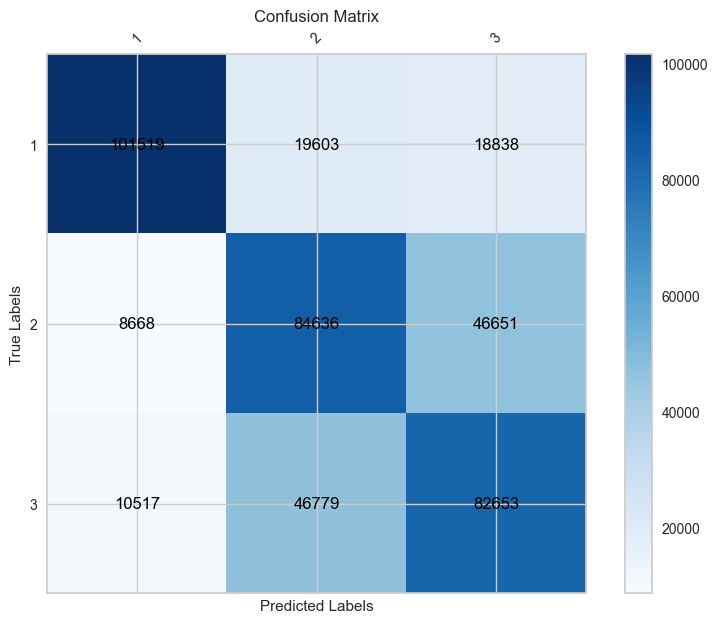

*** Classification Metrics ***
F1 Score = 0.6448255078108569
******************************


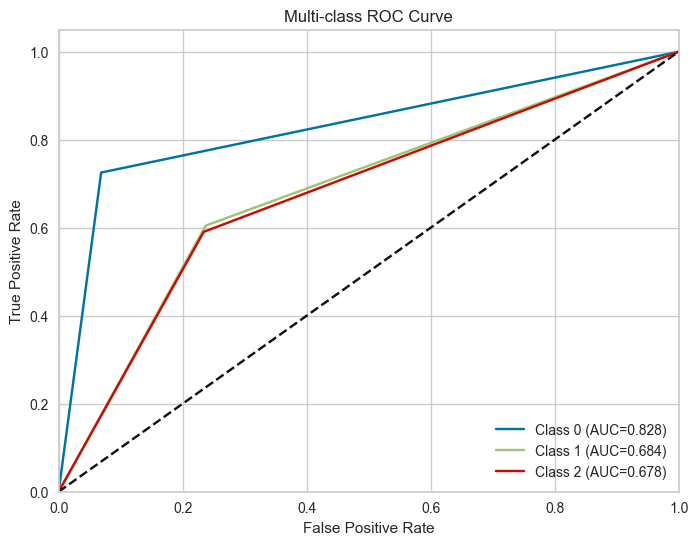

AUC scores for each class: {0: 0.8284007990466695, 1: 0.6837907949775873, 2: 0.6783167034513635}


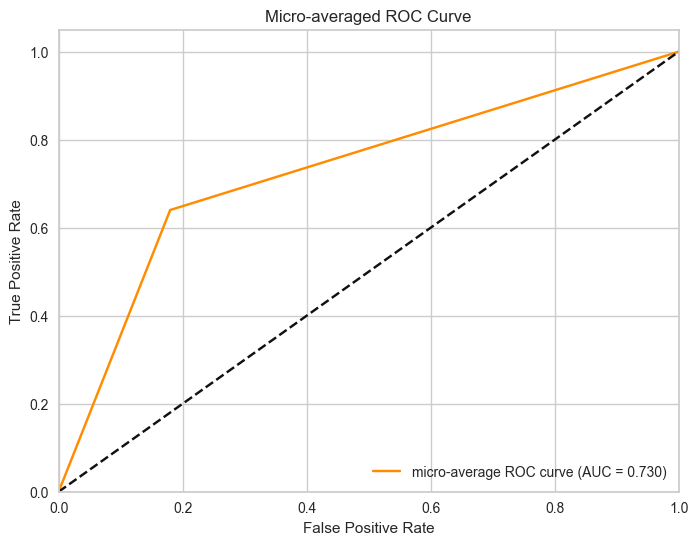

Micro-average ROC AUC: 0.730169769258617
Mean ROC AUC: 0.7301695166835593


In [33]:
# Evaluer le modèle sur les données train
y_train_pred = logreg.predict(X_train_prep)
evaluate_model_multiclass(y_train, y_train_pred, logreg.classes_)

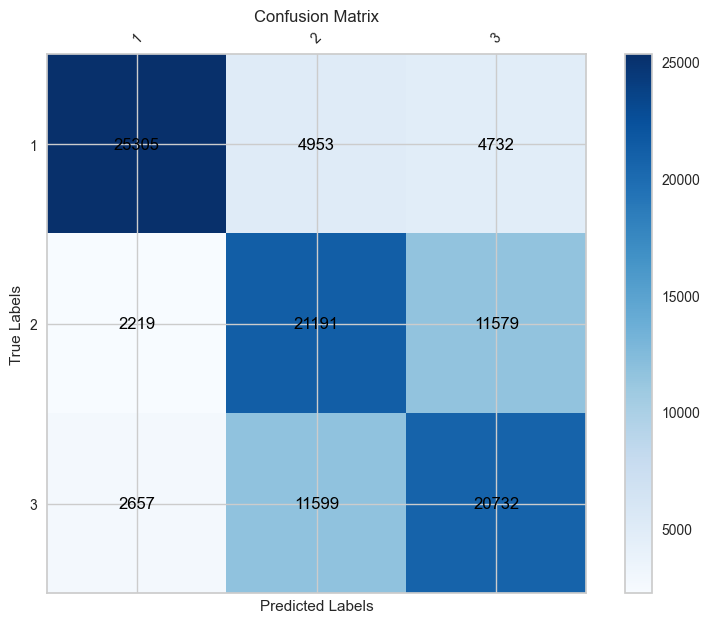

*** Classification Metrics ***
F1 Score = 0.6449779371750248
******************************


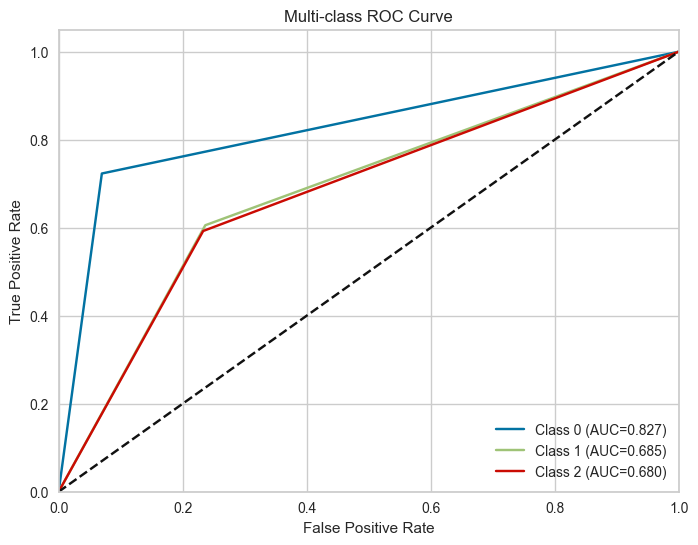

AUC scores for each class: {0: 0.8267632963695829, 1: 0.6845580039440967, 2: 0.6797309023996293}


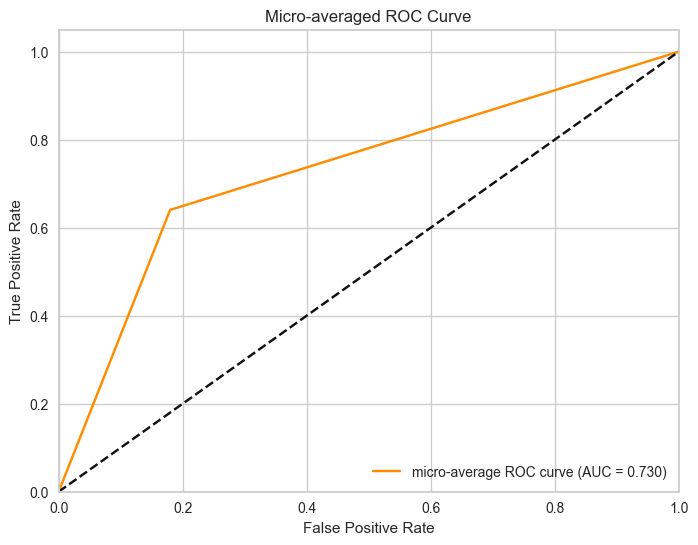

Micro-average ROC AUC: 0.730350967446912
Mean ROC AUC: 0.7303507925400552


In [34]:
# Evaluer le modèle sur les données test
y_test_pred = logreg.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logreg.classes_)

<font color='red'>**Commentaire**</font> 

Ajoutons une pénalisation pour tenter d'améliorer le modèle.

## Régression logistique + pénalité

In [35]:
dict_models_pen = {
    'Logistic Regression (Ridge)': logregRidge,
    'Logistic Regression (Lasso)': logregLasso,
    'Logistic Regression (Elastic Net)': logregElasticNet
}



*** Logistic Regression (Ridge) ***


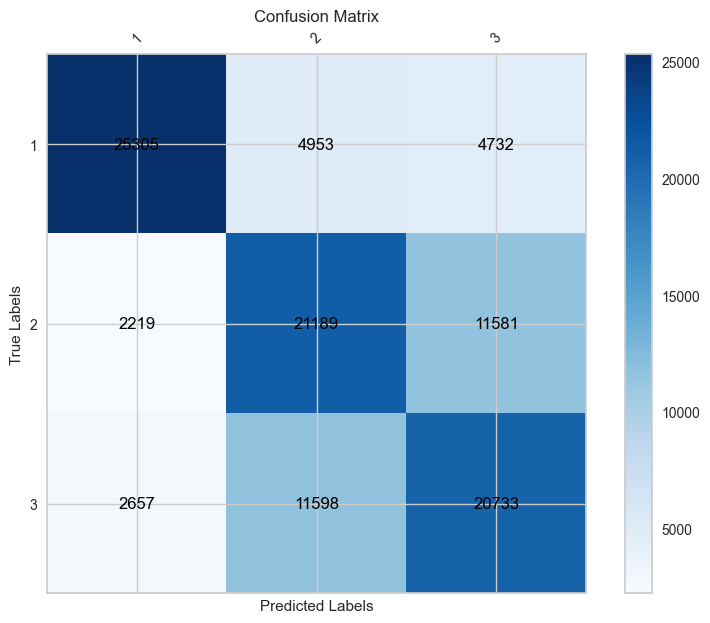

*** Classification Metrics ***
F1 Score = 0.6449688800248122
******************************


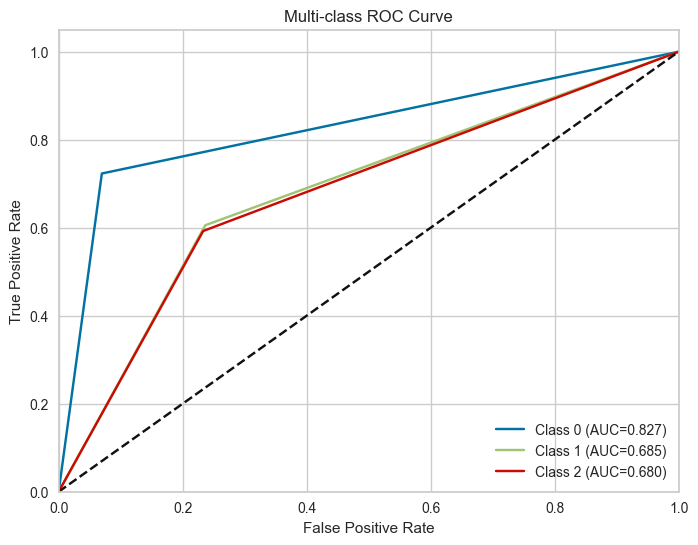

AUC scores for each class: {0: 0.8267632963695829, 1: 0.684536568635857, 2: 0.6797309030122681}


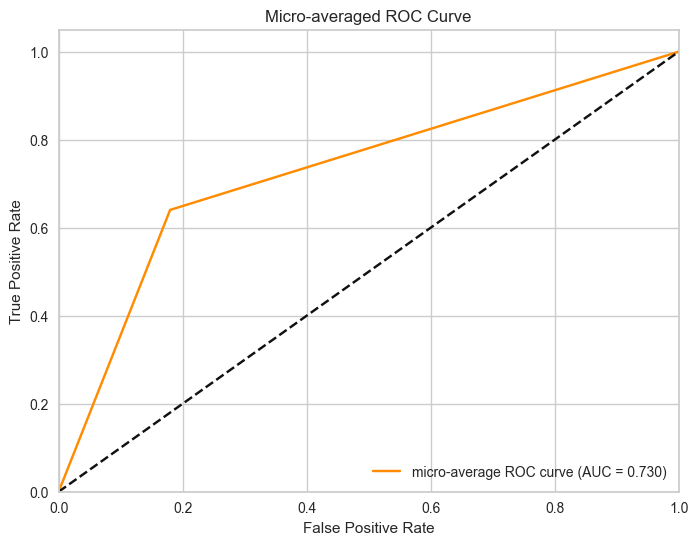

Micro-average ROC AUC: 0.7303438223441654
Mean ROC AUC: 0.7303436475904683


*** Logistic Regression (Lasso) ***


c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


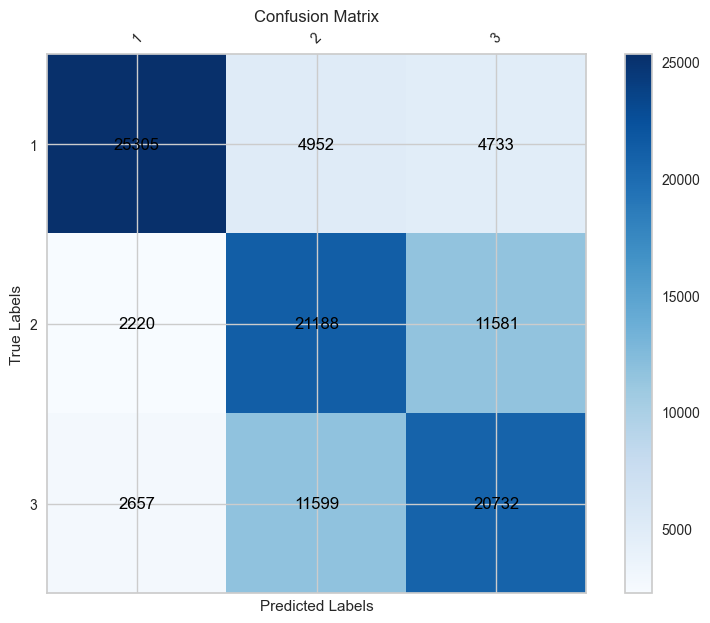

*** Classification Metrics ***
F1 Score = 0.6449491574063647
******************************


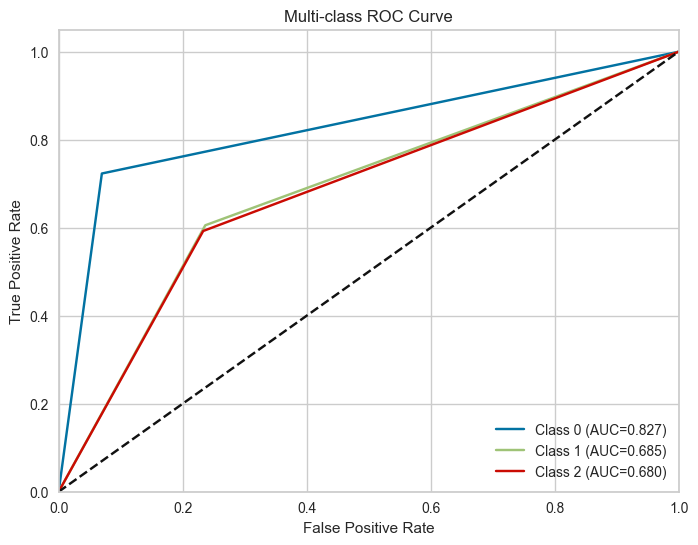

AUC scores for each class: {0: 0.8267561511647299, 1: 0.6845222784303638, 2: 0.6797094673977001}


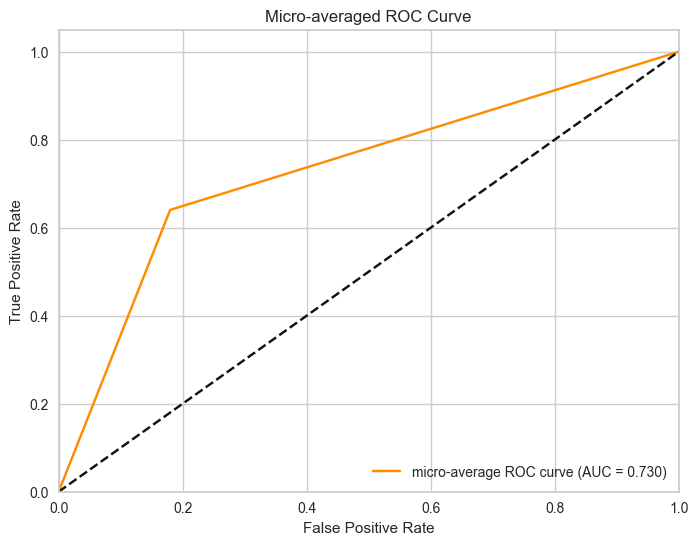

Micro-average ROC AUC: 0.7303295321386722
Mean ROC AUC: 0.7303293572828664


*** Logistic Regression (Elastic Net) ***


c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


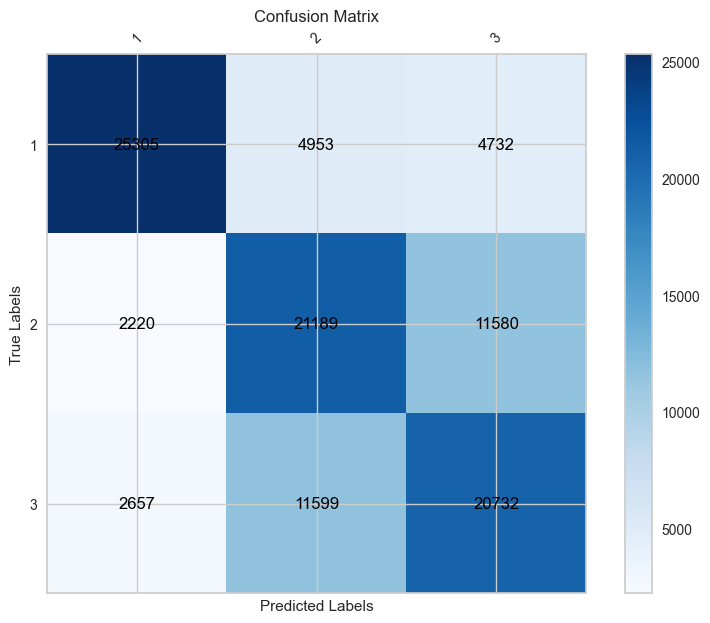

*** Classification Metrics ***
F1 Score = 0.6449583101090024
******************************


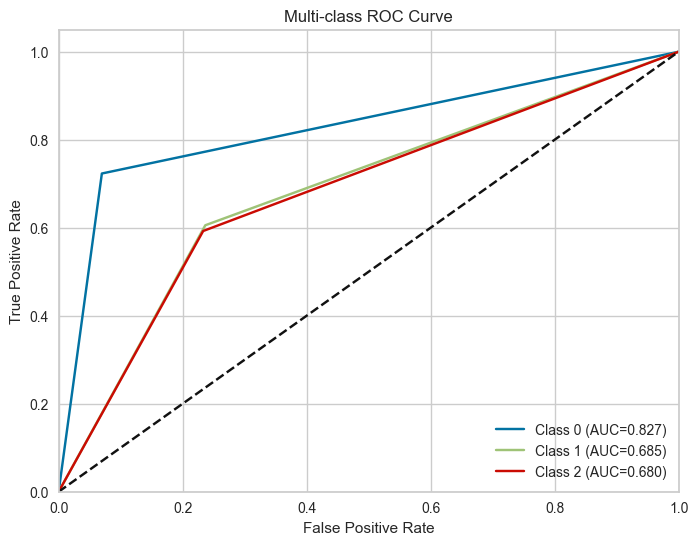

AUC scores for each class: {0: 0.8267561511647299, 1: 0.6845294235331103, 2: 0.6797237573989863}


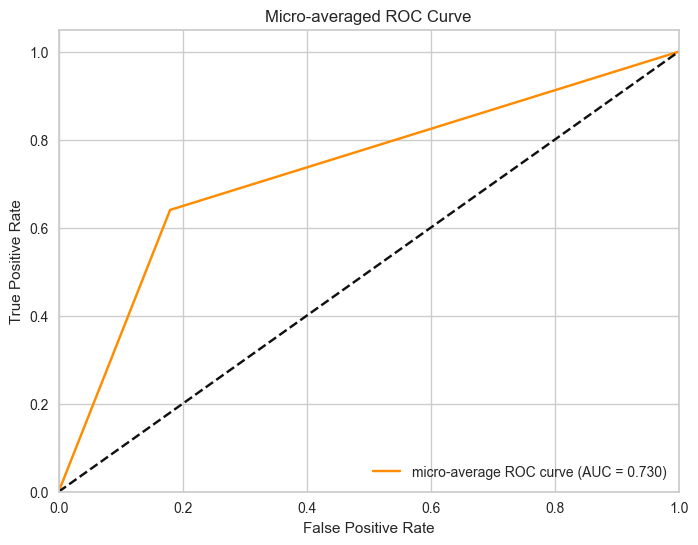

Micro-average ROC AUC: 0.7303366772414186
Mean ROC AUC: 0.7303365023345614


In [38]:
# Evaluate all models
for name, model in dict_models_pen.items():
    print('\n')
    print(f"*** {name} ***")
    model.fit(X_train_prep, y_train)
    y_test_pred = model.predict(X_test_prep)
    evaluate_model_multiclass(y_test, y_test_pred, model.classes_)

### Courbes de validation

In [51]:
def plot_validation_curve(model, X_train, y_train, param_name, param_range, cv=5, scoring='f1_weighted', title=None):
    """
    Plot validation curve for a logistic regression model.

    Args:
        model: The logistic regression model to evaluate.
        X_train: Training data.
        y_train: Training labels.
        param_name: Name of the parameter to vary.
        param_range: Range of parameter values to evaluate.
        cv: Number of cross-validation folds.
        scoring: Scoring method to use.
        title: Title of the plot.
    """
    train_scores, val_scores = validation_curve(
        model, 
        X_train, 
        y_train, 
        param_name=param_name, 
        param_range=param_range, 
        cv=cv, 
        scoring=scoring
    )

    plt.figure(figsize=(12, 4))
    plt.plot(param_range, train_scores.mean(axis=1), label='train')
    plt.plot(param_range, val_scores.mean(axis=1), label='validation')
    plt.legend()

    print("train scores:", train_scores.mean(axis=1))
    print("val scores:", val_scores.mean(axis=1))

    # Find the best C (maximum validation score)
    best_C_idx = np.argmax(val_scores.mean(axis=1))
    best_C = param_range[best_C_idx]

    if title is not None:
        plt.title(f'{title} (Best C: {best_C:.5f})')
    else:
        # plt.title(f'Validation Curve for {model.__class__.__name__}')
        plt.title(f'Validation Curve for Ridge Logistic Regression (Best C: {best_C:.5f})')
    plt.ylabel('Score')
    plt.xlabel(f'{param_name} (Regularization parameter)')
    plt.show()

train scores: [0.63931992 0.64467166 0.64475155 0.64478355 0.64479861 0.6447914
 0.64479375 0.64479748 0.64480209 0.64480485 0.64480651 0.64480996
 0.64480536 0.64480643 0.64480293 0.64480414 0.64480463 0.64480927
 0.64480749 0.64480737 0.64481145 0.64481083 0.64480971 0.644808
 0.64481146 0.64481087 0.64481315 0.6448143  0.64481434 0.64481373]
val scores: [0.63932318 0.64462624 0.6447527  0.64477332 0.64477903 0.64478105
 0.64477169 0.64478081 0.64480612 0.64480618 0.6448106  0.6448152
 0.64482213 0.6448337  0.64483127 0.64483356 0.64483581 0.64483351
 0.64483351 0.6448335  0.64482658 0.64483574 0.64483114 0.64483574
 0.64484269 0.64483802 0.64483804 0.64483804 0.64483354 0.64483343]


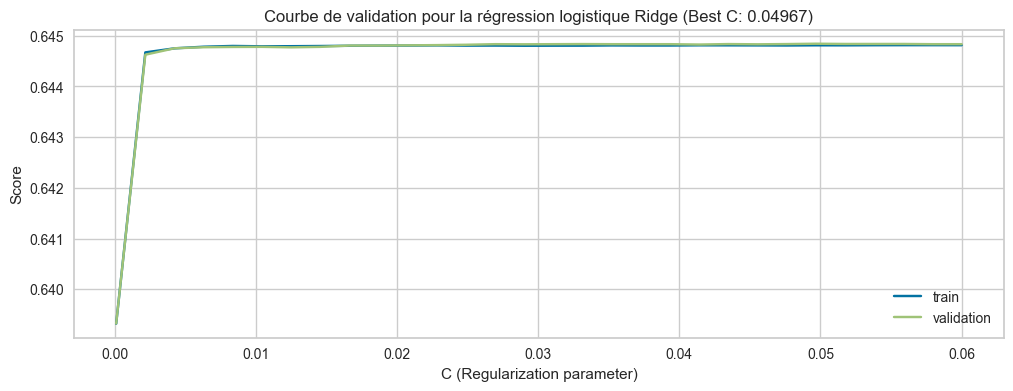

In [52]:
list_hyperparams = np.linspace(0.0001, 0.06, 30)

plot_validation_curve(
    logregRidge,
    X_train_prep, 
    y_train, 
    param_name='C', 
    param_range=list_hyperparams, 
    cv=5, 
    scoring='f1_weighted',
    title="Courbe de validation pour la régression logistique Ridge"
)

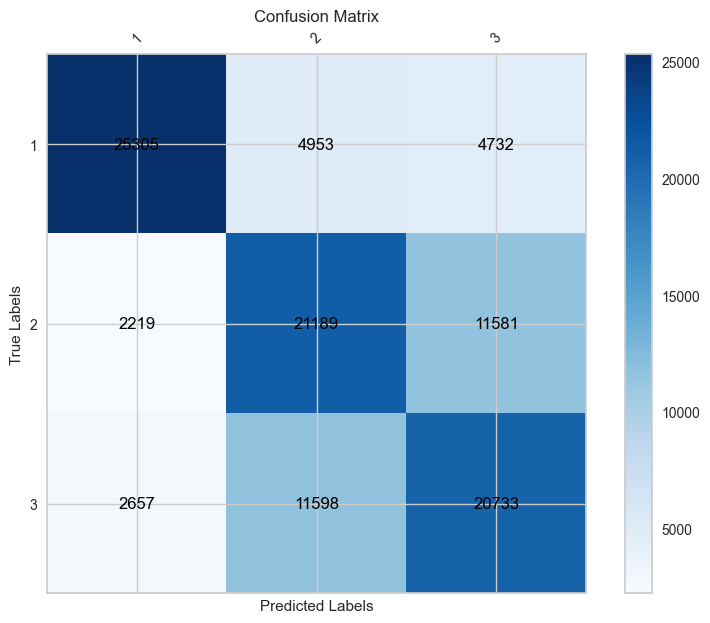

*** Classification Metrics ***
F1 Score = 0.6449688800248122
******************************


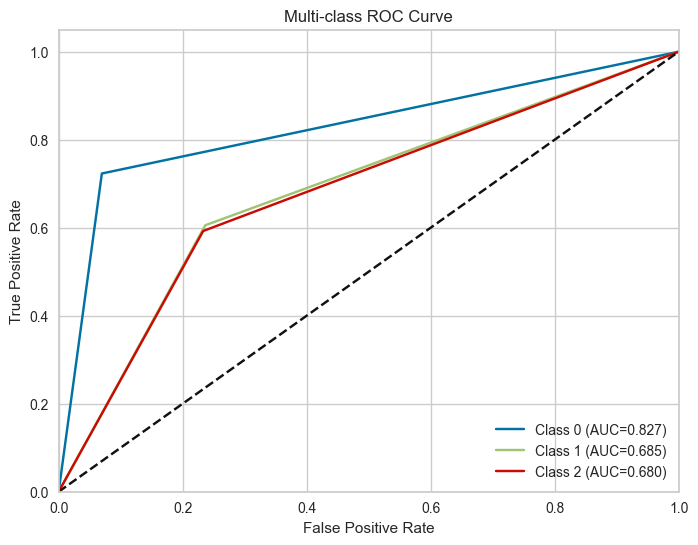

AUC scores for each class: {0: 0.8267632963695829, 1: 0.684536568635857, 2: 0.6797309030122681}


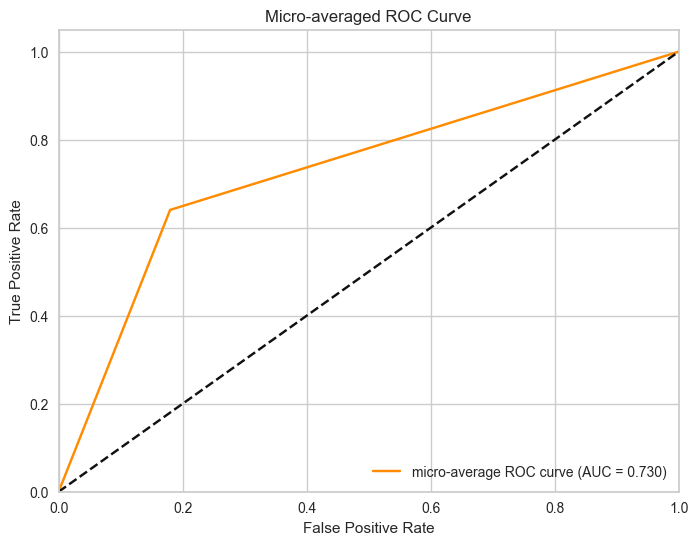

Micro-average ROC AUC: 0.7303438223441654
Mean ROC AUC: 0.7303436475904683


In [53]:
# Entrainer un modèle de régression logistique Ridge avec le meilleur hyperparamètre
logregRidge = LogisticRegression(C=0.04967, penalty='l2', solver='lbfgs', tol=10e-6, random_state=42)
logregRidge.fit(X_train_prep, y_train)

# Prédire les données test et évaluer le modèle
y_test_pred = logregRidge.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logregRidge.classes_)

In [61]:
# # Courbe d'apprentissage pour la régression logistique Lasso
# plot_validation_curve(
#     logregLasso,
#     X_train_prep, 
#     y_train, 
#     param_name='C', 
#     param_range=list_hyperparams, 
#     cv=5, 
#     scoring='f1_weighted',
#     title="Courbe de validation pour la régression logistique Lasso"
# )

In [62]:
# # Entrainer un modèle de régression logistique Lasso avec le meilleur hyperparamètre
# logregLasso = LogisticRegression(C=0.00423, penalty='l1', solver='saga', random_state=42)
# logregLasso.fit(X_train_up, y_train_up)

# # Prédire les données test et évaluer le modèle
# y_test_pred = logregLasso.predict(X_test_prep)
# evaluate_model_multiclass(y_test, y_test_pred, logregLasso.classes_)

### Optimisation des hyper paramètres avec Optuna

In [66]:
# Définir une fonction objectif pour l'optimisation des hyperparamètres
def objective(trial):
    """
    Objective function for hyperparameter optimization.
    """
    # Définir l'espace de recherche pour les hyperparamètres
    C = trial.suggest_loguniform('C', 0.0001, 0.1)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None

    # Vérifier les combinaisons valides de solveurs et de pénalités
    if solver == 'lbfgs' and penalty not in ['l2', 'none']:
        raise optuna.exceptions.TrialPruned()
    if solver != 'saga' and penalty == 'elasticnet':
        raise optuna.exceptions.TrialPruned()
    
    # Initialiser le modèle
    hyperparameters = {
        'C': C,
        'penalty': penalty,
        'solver': solver,
        'tol': 1e-6,
        'max_iter': 1000,
        'random_state': 42
    }
    if l1_ratio is not None:
        hyperparameters['l1_ratio'] = l1_ratio

    model = LogisticRegression(**hyperparameters)

    # Entraîner le modèle
    model.fit(X_train_prep, y_train)

    # Prédire les résultats sur l'ensemble de test
    y_test_pred = model.predict(X_test_prep)

    # Calculer le score F1
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    return f1

In [67]:
import optuna

# Optimiser les hyperparamètres de la régression logistique Ridge

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2024-06-11 22:09:09,562] A new study created in memory with name: no-name-b775647b-cded-4406-be4b-b6756835ccfc
C:\Users\33667\AppData\Local\Temp\ipykernel_29468\4054425019.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.0001, 0.1)
c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-06-11 22:15:55,059] Trial 0 finished with value: 0.6448187550323489 and parameters: {'C': 0.006948915389640227, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5458422666537074}. Best is trial 0 with value: 0.6448187550323489.
C:\Users\33667\AppData\Local\Temp\ipykernel_29468\4054425019.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Number of finished trials:  100
Best trial: {'C': 0.010606096740994778, 'penalty': 'l2', 'solver': 'saga'}
